In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
n = int(input())
E = float(input())
Area = float(input())

8
1e4
0.111


In [3]:
Nodes = []                    #Nodal coord of size n,2
A = [[]]                       #adjacency matrix of n,n size
C = [[]]                       #constraints of size n,2      1 = free, 0 = fixed
P = [[]]                       #ext/nodal loads of size n,2
Ur = [0,0,0,0]               #support Disp

In [4]:
#input Nodes
for i in range(0,n):
    temp1 = []
    temp1.append(int(input()))
    temp1.append(int(input()))
    
    Nodes.append(temp1)
# Nodes.append([0, 120])
# Nodes.append([120,120])
# Nodes.append([240, 120])
# Nodes.append([360, 120])
# Nodes.append([0,0])
# Nodes.append([120,0])
# Nodes.append([240,0])
# Nodes.append([360, 0])

#input A
for i in range(0,n):
    temp2 = []
    for j in range(0,n):
        temp2.append(int(input()))    
    A.append(temp2)

# A = [[0,1,0,0,0,1,0,0],
# [1,0,1,0,1,1,1,0],
# [0,1,0,1,0,1,1,1],
# [0,0,1,0,0,0,1,1],
# [0,1,0,0,0,1,0,0],
# [1,1,1,0,1,0,1,0],
# [0,1,1,1,0,1,0,1],
# [0,0,1,1,0,0,1,0]]

    
#input C
for i in range(0,n):
    temp3 = []
    temp3.append(int(input()))
    temp3.append(int(input()))
    
    C.append(temp3)

# C = [[0,0],
# [1,1],
# [1,1],
# [1,1],
# [0,0],
# [1,1],
# [1,1],
# [1,1]]

    
#input P
for i in range(0,n):
    temp4 = []
    temp4.append(int(input()))
    temp4.append(int(input()))
    
    P.append(temp4)

# P = [[0,0],
# [0,0],
# [0,0],
# [0,0],
# [0,0],
# [0,0],
# [0,0],
# [0,-10]]


In [5]:
Nodes = np.array(Nodes).astype(float)        #Nodal coord of size n,2      all have been converted to np matrices
A = np.array(A)                                     #adjacency matrix of n,n size  0 if not cconnected, 1 if connected
C = np.array(C)                                     #constraints of size n,2
P = np.array(P).astype(float)                       #ext/nodal loads of size n,2

In [10]:
bars = []                   #a list extracted from adjacency of connectivity of node i,j i.e. each element is a bar
for i in range(0,n):
    for j in range(0,i):
        if A[i][j]==1 :
            bars.append([i,j])
        else:
            continue
#     print(bars)
bars = np.array(bars)

In [20]:
#truss analysis
def truss_anal():
    No_nodes = n
    No_edges = len(bars)
    DOF = 2
    NDOF = DOF*No_nodes
    
    
    d = Nodes[bars[:,1],:] - Nodes[bars[:,0],:]
    L = np.sqrt((d**2).sum(axis=1))
    angle = d.T/L
    a = np.concatenate((-angle.T,angle.T),axis=1)
    
    K = np.zeros([NDOF,NDOF])             #total stiffness matrix
    
    for k in range(0,No_edges):                 #running a loop on all the individual members of bars to get local stiffness matrix
            aux = 2*bars[k,:]
            index = np.r_[aux[0]:aux[0]+2,aux[1]:aux[1]+2]         #create a list of 4 DOF indices, 2 for each node of bar
            #using k = (aT) . EA/L . (a)   to get local stiffness matrix
            
            k_local = np.dot((a[k][np.newaxis].T)*Area*E,a[k][np.newaxis])/(L[k])        #newaxis adds another row/can  be used for column too but here we see rows only
            
            K[np.ix_(index,index)] = K[np.ix_(index,index)] + k_local #takes N 1-D sequences and returns N outputs with N dimensions each
    
    FreeDOF = C.flatten().nonzero()[0]
    SupportDOF = (C.flatten()==0).nonzero()[0]
    
    Kff = K[np.ix_(FreeDOF,FreeDOF)]
    Kfr = K[np.ix_(FreeDOF,SupportDOF)]
    Krf = Kfr.T
    Krr = K[np.ix_(SupportDOF,SupportDOF)]
    
    Pf = P.flatten()[FreeDOF] #only input from free DOF's
    Uf = np.linalg.solve(Kff,Pf)
    
    U = C.astype(float).flatten()
    U[FreeDOF] = Uf
    U[SupportDOF] = Ur
    U = U.reshape(No_nodes,DOF)
    
    u = np.concatenate((U[bars[:,0]],U[bars[:,1]]),axis = 1)       #this u at index i contains a list of fous elements of displacement of the bar i in four DOF at the two nodes
#     print(u[0])
    #For Internal forces N = EA/L (a) * (u)
    
    N = (E*Area/L[:])*(a[:]*u[:]).sum(axis=1)
    
    #Reaction Forces
    
    R = (Krf[:]*Uf).sum(axis=1) + (Krr[:]*Ur).sum(axis=1)
    R = R.reshape(2,DOF)
    
    return np.array(N), np.array(R), U

In [21]:
def Plot(Nodes, c, lt, lw, lg):
    for i in range(0,len(bars)):
        xi,xf = Nodes[bars[i,0],0], Nodes[bars[i,1],0]
        yi,yf = Nodes[bars[i,0],1], Nodes[bars[i,1],1]
        
        line, = plt.plot([xi,xf],[yi,yf],color = c,linestyle = lt,linewidth = lw)
    line.set_label(lg)
    plt.legend(prop={'size': 8})

Axial Forces (positive = tension, negative = compression)
[[ 24.9936627 ]
 [ 15.05486106]
 [  4.476552  ]
 [ -7.06210552]
 [  7.0800301 ]
 [  0.04852377]
 [ -7.14865307]
 [-25.0063373 ]
 [  6.99348255]
 [ -0.46858694]
 [ -6.33080055]
 [-14.94513894]
 [  7.81133508]
 [  4.476552  ]
 [ -5.523448  ]]
Reacting Forces (positive = upward, negative = downward)
[[-30.          5.0063373]
 [ 30.          4.9936627]]
Displacement at nodes
[[  0.           0.        ]
 [  2.70201759  -4.22895932]
 [  4.32957014 -12.81281781]
 [  4.8135217  -23.26358172]
 [  0.           0.        ]
 [ -2.70338782  -4.23420514]
 [ -4.31907851 -12.76215976]
 [ -4.91620803 -23.74753328]]


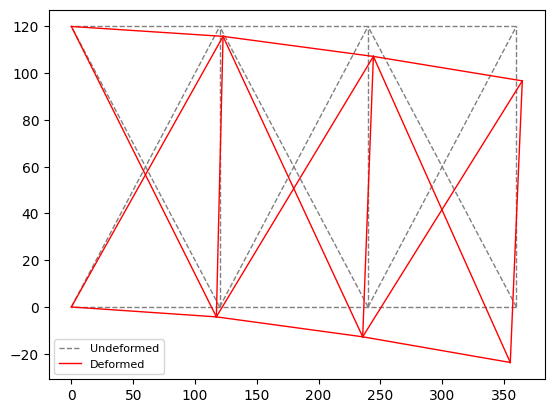

In [22]:
N, R , U = truss_anal()
print('Axial Forces (positive = tension, negative = compression)')
print(N[np.newaxis].T)
print('Reacting Forces (positive = upward, negative = downward)')
print(R)
print('Displacement at nodes')
print(U)
Plot(Nodes,'gray','--',1,'Undeformed')

scale = 1
Deformed_nodes = U*scale + Nodes
Plot(Deformed_nodes,'red','-',1,'Deformed')
